In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import numpy as np
import scipy.io as sio
import time
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Input, InputLayer, Flatten, Conv2D,MaxPooling2D,Conv2DTranspose,LeakyReLU
import seaborn as sn
from keras.utils.vis_utils import plot_model
import math
import pandas as pd
import matplotlib.gridspec as gridspec
import csv
from scipy.io import loadmat

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
def mean2(x):
    y = np.sum(x) / np.size(x);
    return y

def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / math.sqrt((a*a).sum() * (b*b).sum());
    return r

In [ ]:
#Xtest_digits=np.transpose(sio.loadmat('Xtest_digits_mnist.mat')['Xtest_digits'].squeeze()).reshape([10000,28*28],order='F') 
Xtrain_digits=np.transpose(sio.loadmat('/content/drive/My Drive/Colab Notebooks/Xtrain_digits_mnist.mat')['Xtrain_digits'].squeeze()).reshape([60000,28*28],order='F')
#outputTest_digits=np.transpose(sio.loadmat('outputTest_digits_mnist.mat')['outputTest_digits'].squeeze()).reshape([10000,28*28],order='F')
outputTrain_digits=np.transpose(sio.loadmat('/content/drive/My Drive/Colab Notebooks/outputTrain_digits_mnist.mat')['outputTrain_digits'].squeeze()).reshape([60000,28*28],order='F')
#n_low_vec_test=sio.loadmat('n_low_vec_test.mat')['n_low_vec_test']
n_low_vec=sio.loadmat('/content/drive/My Drive/Colab Notebooks/n_low_vec_train.mat')['n_low_vec']
y_train_labels=sio.loadmat('/content/drive/My Drive/Colab Notebooks/mnist_train_labels.mat')['YTrain'] 


n = 7 # an odd number of digits to show in the figure
n_vals=[round(np.random.uniform()*100) for _ in range(n)]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 Encoder (Sequential)        (None, 7, 7, 60)          1347274   
                                                                 
 Decoder (Sequential)        (None, 28, 28, 1)         7967015   
                                                                 
Total params: 9,314,289
Trainable params: 9,314,289
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/70
1250/1250 - 165s - loss: 1.0690 - val_loss: 0.6367 - 165s/epoch - 132ms/step
Epoch 2/70
1250/1250 - 157s - loss: 0.5826 - val_loss: 0.5509 - 157s/epoch - 125ms/step
Epoch 3/70
1250/1250 - 157s - loss: 0.5190 - val_loss: 0.5154 - 157s/epoch - 125ms/step
Epoch 4/70
1250/1250 - 156s - loss: 0.4880 - v

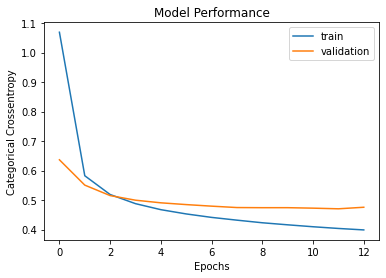

In [ ]:
train_inds_all=np.array([round(i) for i in np.linspace(0,59999,60000)])#to become indices of train/val later
X_train, X_val, output_digits_train, output_digits_val, train_inds_train, train_inds_val= train_test_split(Xtrain_digits, 
                                                    outputTrain_digits,train_inds_all,
                                                    stratify=y_train_labels, 
                                                    test_size=0.1666666, random_state=42)

X_train_train, X_train_val, output_digits_train_train, output_digits_train_val=train_test_split(X_train,output_digits_train,
                                                              stratify=y_train_labels[train_inds_train],
                                                              test_size=0.2, random_state=10)

# Train the Autoencoder
coding_size=60
filter_size=11
kernel_size=101
pool_size=2
convpad='same'
poolpad='same'

def build_conv_autoencoder(filter_size, kernel_size, pool_size, coding_size,convpad,poolpad):
    # # The encoder
    encoder = Sequential(name="Encoder")
    # encoder.add(InputLayer((784,)))
    encoder.add(Conv2D(filter_size, kernel_size, activation=LeakyReLU(), padding=convpad))
    encoder.add(MaxPooling2D(pool_size, padding=poolpad))
    encoder.add(Conv2D(filter_size, kernel_size, activation=LeakyReLU(), padding=convpad))
    encoder.add(MaxPooling2D(pool_size, padding=poolpad))
    # encoder.add(Dense(dense_size,activation='relu'))
    encoder.add(Dense(coding_size,activation=LeakyReLU()))

    # # The decoder
    decoder = Sequential(name="Decoder")
    # decoder.add(InputLayer((coding_size,)))#
    decoder.add(Conv2DTranspose(filter_size, kernel_size, strides=2, activation=LeakyReLU(), padding=convpad))
    decoder.add(Conv2DTranspose(filter_size, kernel_size, strides=2, activation=LeakyReLU(), padding=convpad))
    decoder.add(Conv2D(1, (1,1), activation=LeakyReLU(), padding='same'))

    return encoder, decoder    



encoder_rc, decoder_rc = build_conv_autoencoder(filter_size, kernel_size, pool_size, coding_size,convpad,poolpad)

inpt=Input(shape=(28,28,1))
code_rc = encoder_rc(inpt)
reconstruction_rc = decoder_rc(code_rc)
autoencoder_rc=Model(inpt,reconstruction_rc)
autoencoder_rc.compile(optimizer='adam', loss='mse')
print(autoencoder_rc.summary())
plot_model(autoencoder_rc, show_shapes=True, to_file='conv_autoencoder_RC.png',expand_nested=True)


filepath="best_model_convTrained_on_RC.hdf5"
mc = ModelCheckpoint(filepath, monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss',verbose=0,min_delta=0.01,patience=5)
callbacks=[es, mc]

train_new=1
if train_new==1:
    classify_model_trained_rc=autoencoder_rc.fit(X_train_train.reshape([len(X_train_train),28,28,1]),output_digits_train_train.reshape([len(X_train_train),28,28,1]),
                                                 validation_data=(X_train_val.reshape([len(X_train_val),28,28,1]), 
                                                 output_digits_train_val.reshape([len(X_train_val),28,28,1])),
                                                 epochs=70,verbose=2,callbacks=callbacks)
    
    best_epoch=np.argmin(classify_model_trained_rc.history['val_loss'])+1
    epochs = len(classify_model_trained_rc.history['loss'])
    
    makeTrainingPlot=1
    if makeTrainingPlot==1: #Make a plot of training progress
        plt.plot(range(epochs),classify_model_trained_rc.history['loss'], label='train')
        plt.plot(range(epochs),classify_model_trained_rc.history['val_loss'],label='validation')
        plt.xlabel('Epochs')
        plt.ylabel("Categorical Crossentropy")
        plt.title('Model Performance')
        plt.legend()
        plt.show()
    autoencoder_rc.load_weights(mc.filepath)
else:
    autoencoder_rc.load_weights(mc.filepath)


In [ ]:
from google.colab import files
files.download(filepath) 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 784)]             0         
                                                                 
 sequential (Sequential)     (None, 120)               398320    
                                                                 
 sequential_1 (Sequential)   (None, 784)               398984    
                                                                 
Total params: 797,304
Trainable params: 797,304
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/70
1250/1250 - 5s - loss: 1.2045 - val_loss: 0.8730 - 5s/epoch - 4ms/step
Epoch 2/70
1250/1250 - 3s - loss: 0.7939 - val_loss: 0.7452 - 3s/epoch - 2ms/step
Epoch 3/70
1250/1250 - 3s - loss: 0.7062 - val_loss: 0.6981 - 3s/epoch - 2ms/step
Epoch 4/70
1250/1250 - 3s - loss: 0.6594 - val_loss: 0.6670 - 3s/e

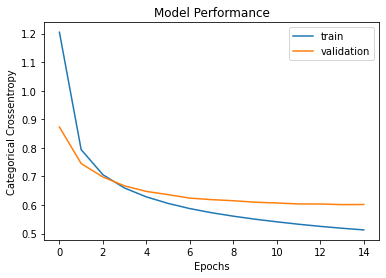

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#MLP on RC
dense_size=440
coding_size=120
def build_MLP_autoencoder(dense_size, coding_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer((784,)))
    encoder.add(Dense(dense_size,activation=LeakyReLU()))
    encoder.add(Dense(coding_size,activation=LeakyReLU()))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((coding_size,)))
    decoder.add(Dense(dense_size,activation=LeakyReLU()))
    decoder.add(Dense(784, activation=LeakyReLU()))
    return encoder, decoder


encoder_mlp_rc, decoder_mlp_rc = build_MLP_autoencoder(dense_size, coding_size)

inpt=Input((784,))
code_rc = encoder_mlp_rc(inpt)
reconstruction_rc = decoder_mlp_rc(code_rc)
autoencoder_mlp_rc=Model(inpt,reconstruction_rc)
autoencoder_mlp_rc.compile(optimizer='adam', loss='mse')
print(autoencoder_mlp_rc.summary())
plot_model(autoencoder_mlp_rc, show_shapes=True, to_file='mlp_autoencoder_RC.png',expand_nested=True)


filepath="best_model_mlpTrained_on_RC.hdf5"
mc = ModelCheckpoint(filepath, monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss',verbose=0,min_delta=0.01,patience=5)
callbacks=[es, mc]

train_new=1
if train_new==1:
    classify_model_trained_mlp_rc=autoencoder_mlp_rc.fit(X_train_train,output_digits_train_train,
                                                 validation_data=(X_train_val, 
                                                 output_digits_train_val),
                                                 epochs=70,verbose=2,callbacks=callbacks)
    
    best_epoch=np.argmin(classify_model_trained_mlp_rc.history['val_loss'])+1
    epochs = len(classify_model_trained_mlp_rc.history['loss'])
    
    makeTrainingPlot=1
    if makeTrainingPlot==1: #Make a plot of training progress
        plt.plot(range(epochs),classify_model_trained_mlp_rc.history['loss'], label='train')
        plt.plot(range(epochs),classify_model_trained_mlp_rc.history['val_loss'],label='validation')
        plt.xlabel('Epochs')
        plt.ylabel("Categorical Crossentropy")
        plt.title('Model Performance')
        plt.legend()
        plt.show()
    autoencoder_mlp_rc.load_weights(mc.filepath)
else:
    autoencoder_mlp_rc.load_weights(mc.filepath)

files.download(filepath) 


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 784)]             0         
                                                                 
 sequential_4 (Sequential)   (None, 120)               653380    
                                                                 
 sequential_5 (Sequential)   (None, 784)               654044    
                                                                 
Total params: 1,307,424
Trainable params: 1,307,424
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/70
1250/1250 - 4s - loss: 1.1983 - val_loss: 0.8652 - 4s/epoch - 3ms/step
Epoch 2/70
1250/1250 - 3s - loss: 0.7814 - val_loss: 0.7352 - 3s/epoch - 3ms/step
Epoch 3/70
1250/1250 - 3s - loss: 0.6858 - val_loss: 0.6858 - 3s/epoch - 3ms/step
Epoch 4/70
1250/1250 - 3s - loss: 0.6341 - val_loss: 0.6583 - 

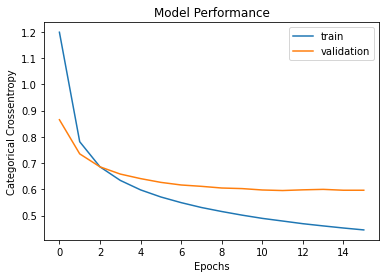

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#%% Deep MLP Trained on RC


dense_size_outer=480
dense_size_inner=460
coding_size=120
def build_deep_autoencoder(dense_size_outer, dense_size_inner, coding_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer((784,)))
    encoder.add(Dense(dense_size_outer,activation=LeakyReLU()))
    encoder.add(Dense(dense_size_inner,activation=LeakyReLU()))
    encoder.add(Dense(coding_size,activation=LeakyReLU()))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((coding_size,)))
    decoder.add(Dense(dense_size_inner,activation=LeakyReLU()))
    decoder.add(Dense(dense_size_outer,activation=LeakyReLU()))
    decoder.add(Dense(784, activation=LeakyReLU()))
    return encoder, decoder

encoder_deep_mlp_rc, decoder_deep_mlp_rc = build_deep_autoencoder(dense_size_outer, dense_size_inner, coding_size)

inpt=Input((784,))
code_rc = encoder_deep_mlp_rc(inpt)
reconstruction_rc = decoder_deep_mlp_rc(code_rc)
autoencoder_deep_mlp_rc=Model(inpt,reconstruction_rc)
autoencoder_deep_mlp_rc.compile(optimizer='adam', loss='mse')
print(autoencoder_deep_mlp_rc.summary())
plot_model(autoencoder_deep_mlp_rc, show_shapes=True, to_file='deep_mlp_autoencoder_RC.png',expand_nested=True)


filepath="best_model_deep_mlpTrained_on_RC.hdf5"
mc = ModelCheckpoint(filepath, monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss',verbose=0,min_delta=0.01,patience=5)
callbacks=[es, mc]

train_new=1
if train_new==1:
    classify_model_trained_deep_mlp_rc=autoencoder_deep_mlp_rc.fit(X_train_train,output_digits_train_train,
                                                 validation_data=(X_train_val, output_digits_train_val),
                                                 epochs=70,verbose=2,callbacks=callbacks)
    
    best_epoch=np.argmin(classify_model_trained_deep_mlp_rc.history['val_loss'])+1
    epochs = len(classify_model_trained_deep_mlp_rc.history['loss'])
    
    makeTrainingPlot=1
    if makeTrainingPlot==1: #Make a plot of training progress
        plt.plot(range(epochs),classify_model_trained_deep_mlp_rc.history['loss'], label='train')
        plt.plot(range(epochs),classify_model_trained_deep_mlp_rc.history['val_loss'],label='validation')
        plt.xlabel('Epochs')
        plt.ylabel("Categorical Crossentropy")
        plt.title('Model Performance')
        plt.legend()
        plt.show()
    autoencoder_deep_mlp_rc.load_weights(mc.filepath)
else:
    autoencoder_deep_mlp_rc.load_weights(mc.filepath)

files.download(filepath)